# Monero Blockchain Analysis (unlock_time)

In [1]:
# Load libraries
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read data and fix data types
unlock_times = pd.read_csv("unlock_times.csv")
unlock_times["bi_timestamp_my"] = pd.to_datetime(unlock_times["bi_timestamp_my"]).dt.strftime("%Y-%m")

unlock_times_grouped = pd.read_csv("unlock_times_grouped.csv")
unlock_times_grouped["bi_timestamp_my"] = pd.to_datetime(unlock_times_grouped["bi_timestamp_my"]).dt.strftime("%Y-%m")

## I. Unlock Time Types

The unlock time field is stored as uint64 and has two valid uses, and a third invalid use.
1. Block unlock time: if the value stored in unlock_time is greater than the current block_id and less than genesis block epoch time then it is interpreted as a block_id
2. Date unlock time: if the value stored in unlock_time is greater than the genesis block epoch time then it is interpreted as a time value
3. Invalid unlock time: if the value stored in unlock_time is less than the current block_id then it is invalid and no lock is applied


| tx_hash                                                          | bi_timestamp | block_id | unlock_time | unlock_time_type    | unlock_time_translation                                    |
|------------------------------------------------------------------|--------------|----------|-------------|---------------------|------------------------------------------------------------|
| 9a3c46b4eb630baa839a02dc8e3837aebe5c56fa2894db26d179db4a5e1143b9 | 1638123716   | 2503313  | 1638134429  | date unlock time    | unlock transaction at Unix epoch time 1638134429           |
| c9ddce6d3dc9b7070c64868d16922f713758cf3b66da5fcd209a71eb4b87baf0 | 1652898110   | 2626343  | 2637445     | block unlock time   | unlock transaction at block_id 2637445                     |
| c2cd3a482bba73b3e9db4d2d580b90c90a5c3d1ad65529fe96d25a3db19ce837 | 1653991278   | 2635430  | 3           | invalid unlock time | unlock_time is less than current block_id, no lock applied |

<br />
<br />
The vast majority of unlock_time usagage is invalid as indicated below. Out of 22,618,036 transactions only 15,825 transactions used unlock_time. And of the 15,825 transactions using unlock_time 15,344 are invalid.

In [3]:
print(pd.DataFrame(unlock_times_grouped.agg({"tx_count": "sum", "invalid_unlock_time": "sum", "block_unlock_time": "sum", "date_unlock_time": "sum"})).T.to_string(index=False))

 tx_count  invalid_unlock_time  block_unlock_time  date_unlock_time
 22618036                15344                465                16


## II. Monthly Utilization of unlock_time

The unlock_time field was used more frequently from the beginning of 2019 through the first half of 2020. Utilization dropped heavily for the second half of 2020 and most of 2021. Recently unlock_time utilization has started to increase.

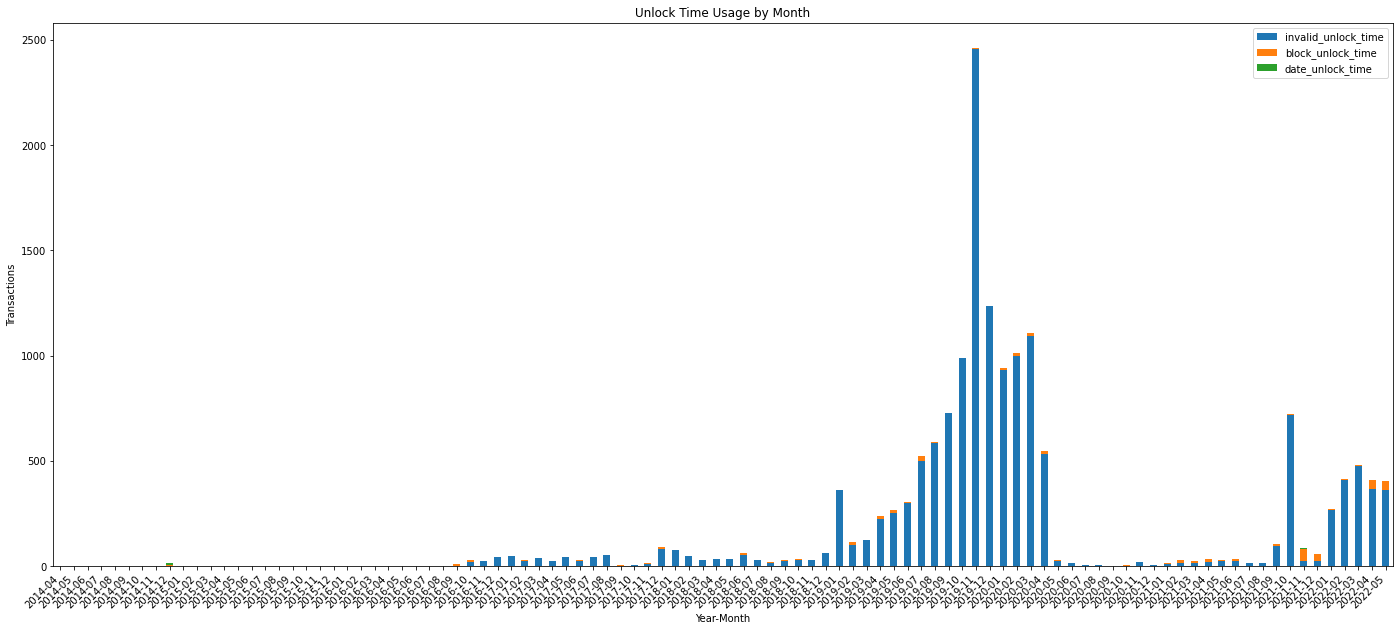

In [4]:
unlock_times_grouped.plot(kind="bar",
                          x="bi_timestamp_my",
                          y=["invalid_unlock_time", "block_unlock_time", "date_unlock_time"],
                          stacked=True,
                          figsize=(24,10))
plt.xticks(rotation=45, horizontalalignment="right")
plt.title("Unlock Time Usage by Month")
plt.xlabel("Year-Month")
plt.ylabel("Transactions");

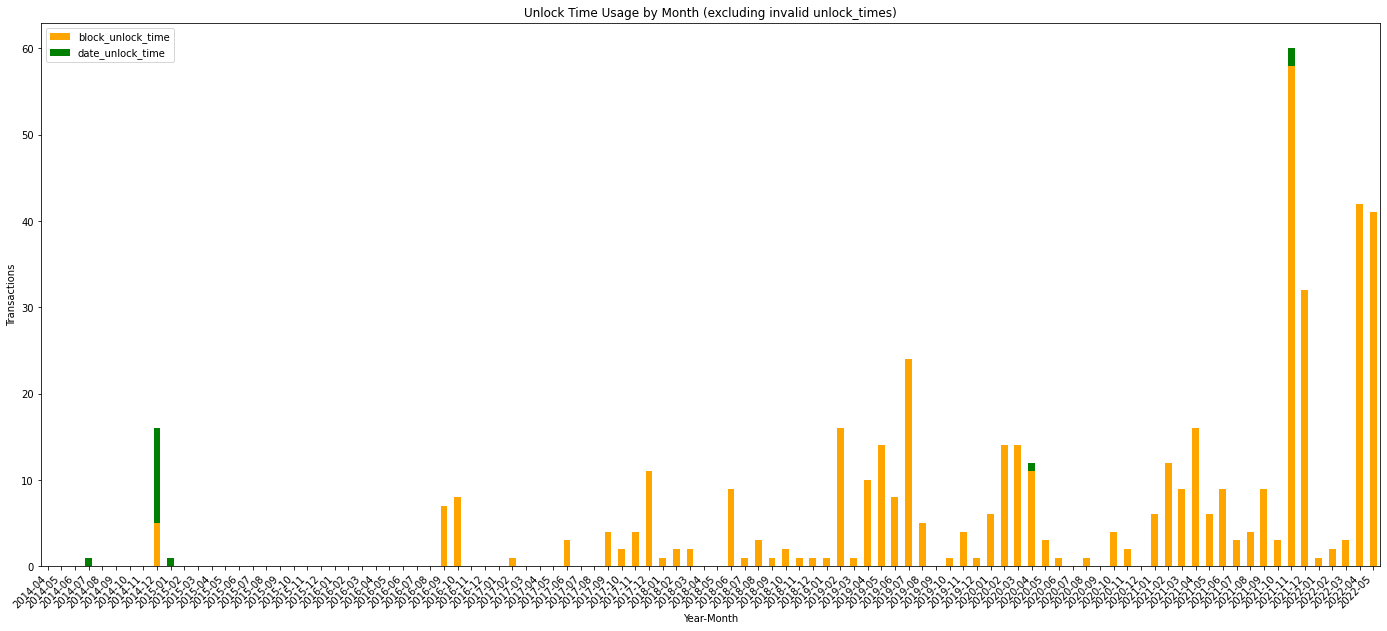

In [5]:
unlock_times_grouped.plot(kind="bar",
                          x="bi_timestamp_my",
                          y=["block_unlock_time", "date_unlock_time"],
                          stacked=True,
                          figsize=(24,10),
                          color=["orange", "green"])
plt.xticks(rotation=45, horizontalalignment="right")
plt.title("Unlock Time Usage by Month (excluding invalid unlock_times)")
plt.xlabel("Year-Month")
plt.ylabel("Transactions");

## III. Date Based unlock_time Utilization

There are only 16 date based unlock_time transactions. They can be summarized as follows:
1. Twelve valid dates used in 2014, most likely testing this feature.
2. One date used in 2015, misconfigured to use milliseconds instead of seconds
3. One date used in 2020 that unlocks after the Universe dies, and referenced on [Twitter](https://twitter.com/Mitchellpkt0/status/1251621277179146240)
4. One date used in 2021 that is less than the block timestamp and thus invalid (unlock_time = 1638036**556**, bi_timestamp = 1638036**785**)
5. One date used in 2021 that is valid

The two transactions in 2021 using unlock_time are within one day of each other and are likely from the same person or persons.

In [6]:
unlock_times_date_based = unlock_times[unlock_times["date_unlock_time"] == 1].sort_values(by="bi_timestamp").reset_index(drop=True).copy()
unlock_times_date_based["unlock_time"] = unlock_times_date_based["unlock_time"].astype(str)
unlock_times_date_based

,tx_hash,block_id,unlock_time,bi_timestamp,bi_timestamp_date,bi_timestamp_my,invalid_unlock_time,block_unlock_time,date_unlock_time
0,65fe3c98baa39c19d0e95a3b38882c5a0af8f99de4286e...,129825,1405393063.0,1405434823,2014-07-15 14:33:43+00:00,2014-07,0,0,1
1,c3a130c2eee219bf938bd757a70f5336a642cf84d6ea24...,339618,1418085498.0,1418085099,2014-12-09 00:31:39+00:00,2014-12,0,0,1
2,96401b8438c736f201ccf87280f5ebc2bb772d2be29438...,342016,1418234455.0,1418234089,2014-12-10 17:54:49+00:00,2014-12,0,0,1
3,39c5e1e59d71f00e930a3074bfc0369ee93fbc8c314482...,342026,1418235188.0,1418234881,2014-12-10 18:08:01+00:00,2014-12,0,0,1
4,4c6176d887de8d9b566fc4eb58d17038e25cdcb0021749...,342036,1418237246.0,1418235502,2014-12-10 18:18:22+00:00,2014-12,0,0,1
5,bffb49c8e6a6e4914c3c4fe7b551481bee3d0789843919...,342274,1418264588.0,1418253833,2014-12-10 23:23:53+00:00,2014-12,0,0,1
6,63b510e1f8bc9d123137b8d9ed493f1cf39c6454042657...,346151,1418490671.0,1418479984,2014-12-13 14:13:04+00:00,2014-12,0,0,1
7,727241302513b2febd9016ce96b6cfe4982db2c843b9a8...,346191,1418482617.0,1418482352,2014-12-13 14:52:32+00:00,2014-12,0,0,1
8,714e40a10148822ae443118343fab35327997b1e307066...,346273,1418488285.0,1418488219,2014-12-13 16:30:19+00:00,2014-12,0,0,1
9,5c42a44d936e42631c5175fbfeb5fe820f6491bdcf1d4e...,346276,1418488561.0,1418488332,2014-12-13 16:32:12+00:00,2014-12,0,0,1


## IV. Block Based unlock_time Utilization

Block unlock times indicate a block at which a transaction should be unlocked. Using a block creation time of two minutes per block an estimated future date for transaction unlock time can be calculated. The first plot below shows the raw difference between transaction block and block unlock time.

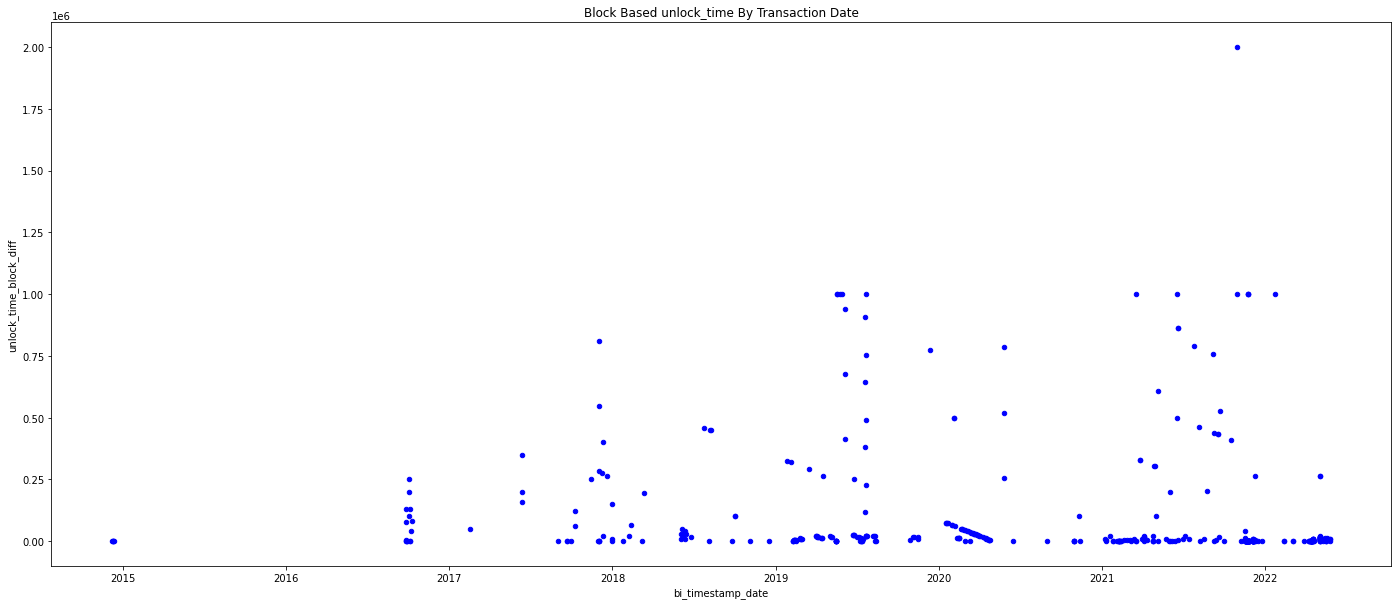

In [7]:
block_unlock_times = unlock_times[unlock_times["block_unlock_time"] == 1].reset_index(drop=True).copy()
block_unlock_times["unlock_time"] = block_unlock_times["unlock_time"].astype(int)
block_unlock_times["bi_timestamp_date"] = pd.to_datetime(block_unlock_times["bi_timestamp_date"])
block_unlock_times["unlock_time_block_diff"] = block_unlock_times["unlock_time"] - block_unlock_times["block_id"]

block_unlock_times.plot(kind="scatter",
                        y="unlock_time_block_diff",
                        x="bi_timestamp_date",
                        color="blue",
                        figsize=(24,10))
plt.title("Block Based unlock_time By Transaction Date");

Converting block based unlock_time to dates it is easy to visualize patterns of unlock times. Three trends emerge:
1. Most block based unlock_times occur within one month of the transaction.
2. In 2019 and 2020 there were many transactions set to unlock in a column around 2020-04-30.
3. In 2021 and 2022 there were transactions set to unlock in 2023-05.

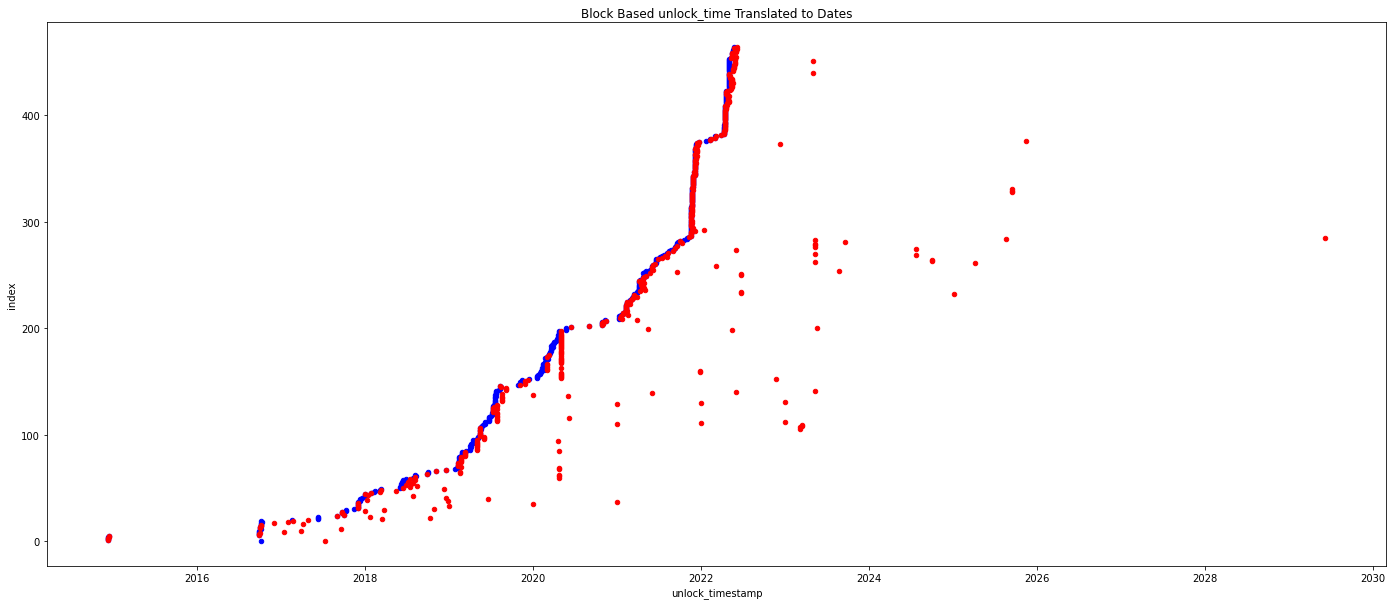

In [8]:
# Old blocks were created once per minute. Use a where clause to correctly estimate a future unlock date for these transactions.
block_unlock_times["unlock_time_block_diff_minutes"] = np.where(block_unlock_times["block_id"] < 1009827,
                                                                pd.to_timedelta(block_unlock_times["unlock_time_block_diff"] * 1, unit="minutes"),
                                                                pd.to_timedelta(block_unlock_times["unlock_time_block_diff"] * 2, unit="minutes"))

block_unlock_times["unlock_timestamp"] = block_unlock_times["bi_timestamp_date"] + block_unlock_times["unlock_time_block_diff_minutes"]

block_unlock_times = block_unlock_times.reset_index()
ax = block_unlock_times.plot(kind="scatter", 
                             y="index", 
                             x="bi_timestamp_date", 
                             color="b")
ax = block_unlock_times.plot(kind="scatter", 
                             y="index", 
                             x="unlock_timestamp", 
                             color="r", 
                             ax=ax, 
                             figsize=(24,10))
plt.title("Block Based unlock_time Translated to Dates");

Approximately half of block based unlock_times are set to occur within one day.

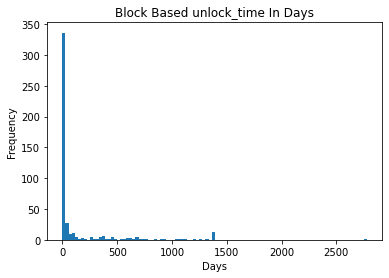

In [9]:
(block_unlock_times["unlock_time_block_diff_minutes"] / np.timedelta64(1, "D")).plot(kind="hist", bins=100)
plt.xlabel("Days")
plt.title("Block Based unlock_time In Days");

Filtering to only block based unlock_time where the estimated unlock time is <= 30 days displays how often this occurs.

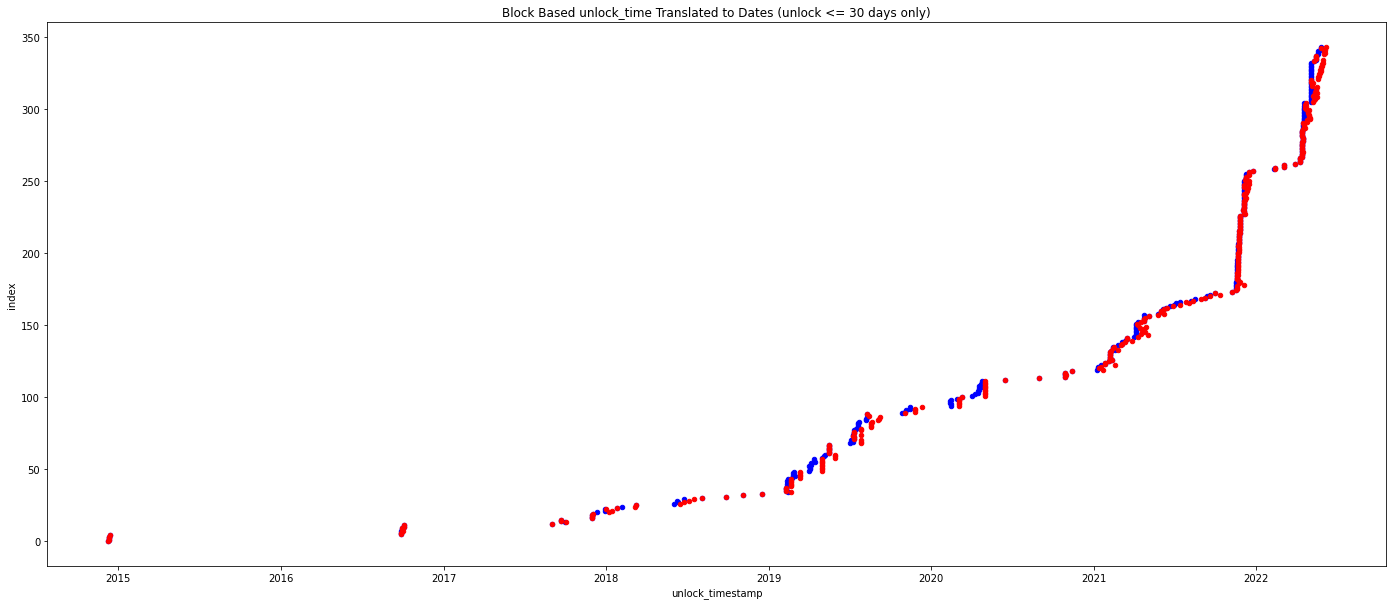

In [10]:
ax = block_unlock_times[block_unlock_times["unlock_time_block_diff_minutes"] <= datetime.timedelta(days=30)].drop("index", axis=1).reset_index(drop=True).reset_index().plot(kind="scatter", 
                             y="index", 
                             x="bi_timestamp_date", 
                             color="b")
ax = block_unlock_times[block_unlock_times["unlock_time_block_diff_minutes"] <= datetime.timedelta(days=30)].drop("index", axis=1).reset_index(drop=True).reset_index().plot(kind="scatter", 
                             y="index", 
                             x="unlock_timestamp", 
                             color="r", 
                             ax=ax, 
                             figsize=(24,10))
plt.title("Block Based unlock_time Translated to Dates (unlock <= 30 days only)");

Filtering to only block based unlock_time where the estimated unlock time is > 30 days displays meaningful trends.

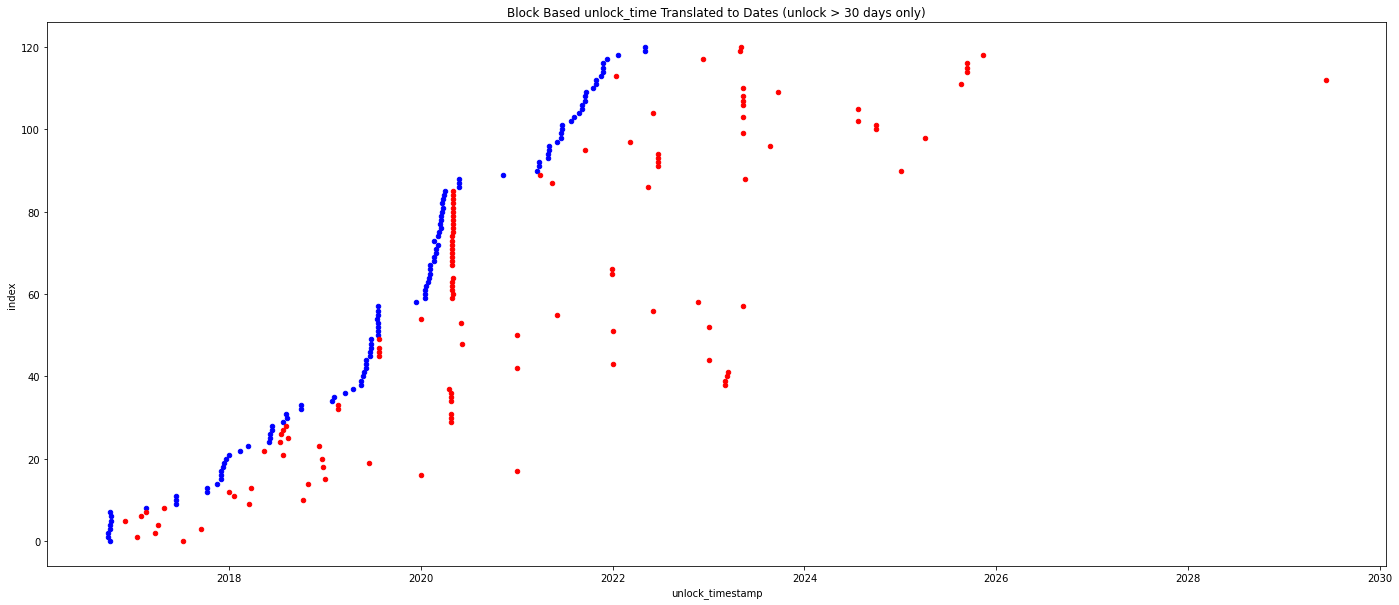

In [11]:
ax = block_unlock_times[block_unlock_times["unlock_time_block_diff_minutes"] > datetime.timedelta(days=30)].drop("index", axis=1).reset_index(drop=True).reset_index().plot(kind="scatter", 
                             y="index", 
                             x="bi_timestamp_date", 
                             color="b")
ax = block_unlock_times[block_unlock_times["unlock_time_block_diff_minutes"] > datetime.timedelta(days=30)].drop("index", axis=1).reset_index(drop=True).reset_index().plot(kind="scatter", 
                             y="index", 
                             x="unlock_timestamp", 
                             color="r", 
                             ax=ax, 
                             figsize=(24,10))
plt.title("Block Based unlock_time Translated to Dates (unlock > 30 days only)");

## V. Invalid unlock_time Utilization

There are two primary groups of invalid unlock times:
1. Unlock times > 100
    1. Most of these are from 2021-09 and are 75,xxx values. At two minutes per block 75,xxx is approximately 100 days, so these may be block based unlock times that forgot to add the current block height. These are likely all from the same person or persons.  
    2. Some of these are unlock_times that are equal to the current block_id or a few blocks less. These are mostly from 2020-07 and 2021-02 and may be from the same person or persons.
2. Unlock times <= 100 (this is the most interesting use)
    1. The ranges [1, 4] and [10, 14] are most common 
    2. Some of these may be incorrect interpretations of unlock_time as days

Comment: Unlock times <= 100 should be compard to tx_extra data to determine if there is additional information being transmitted through the use of "flags" (eg. unlock_time = 1 is a boolean indicator).

In [12]:
invalid_unlock_times = unlock_times[unlock_times["invalid_unlock_time"] == 1].reset_index(drop=True).copy()
invalid_unlock_times["unlock_time"] = invalid_unlock_times["unlock_time"].astype(int)
invalid_unlock_times["bi_timestamp_date"] = pd.to_datetime(invalid_unlock_times["bi_timestamp_date"])

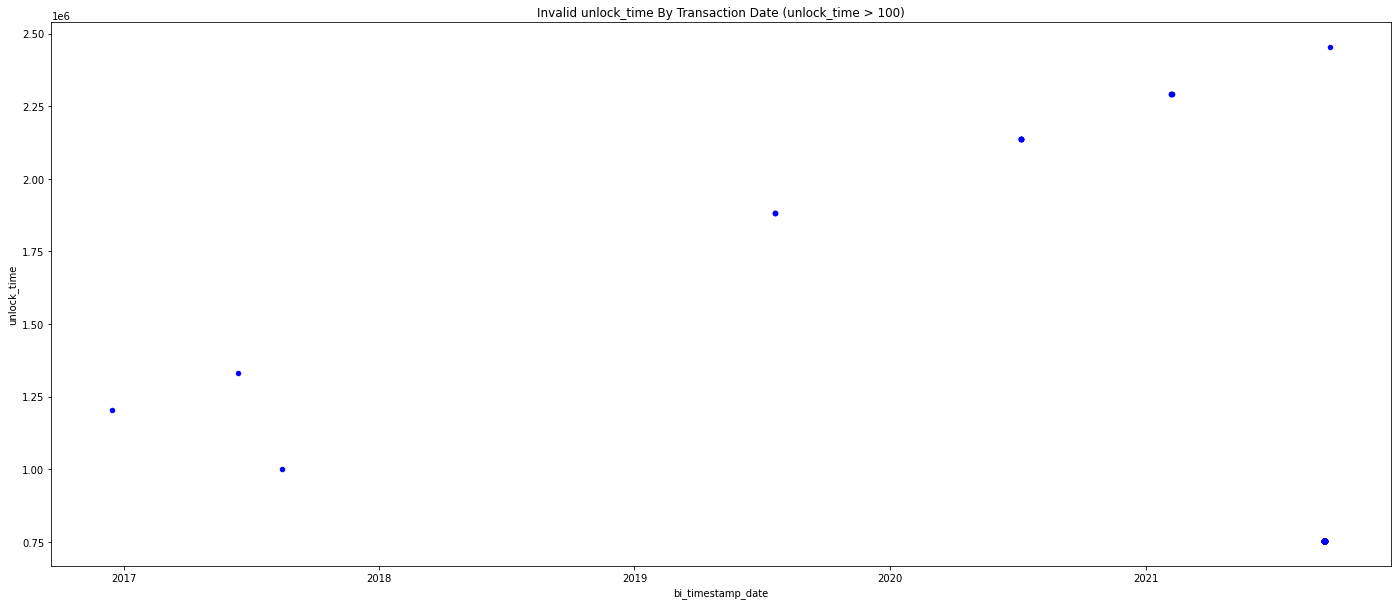

In [13]:
invalid_unlock_times[invalid_unlock_times["unlock_time"] > 100].plot(kind="scatter",
                                                                     y="unlock_time",
                                                                     x="bi_timestamp_date",
                                                                     color="blue",
                                                                     figsize=(24,10))
plt.title("Invalid unlock_time By Transaction Date (unlock_time > 100)");

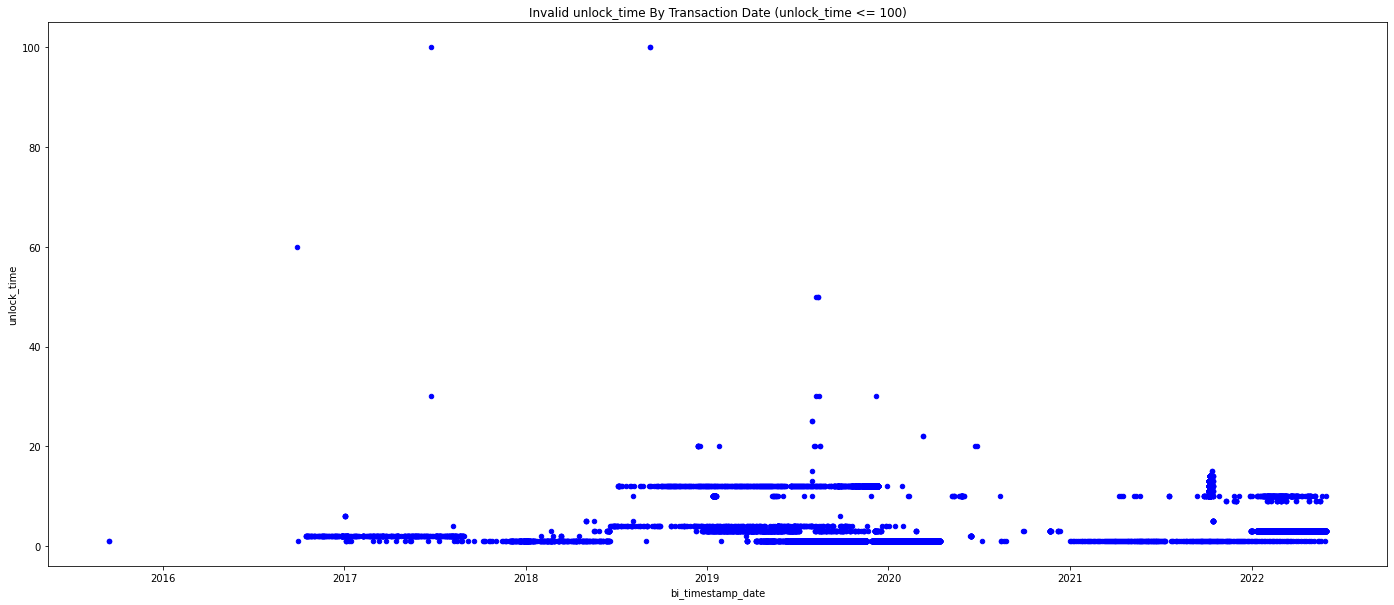

In [14]:
invalid_unlock_times[invalid_unlock_times["unlock_time"] <= 100].plot(kind="scatter",
                                                                       y="unlock_time",
                                                                       x="bi_timestamp_date",
                                                                       color="blue",
                                                                       figsize=(24,10))
plt.title("Invalid unlock_time By Transaction Date (unlock_time <= 100)");

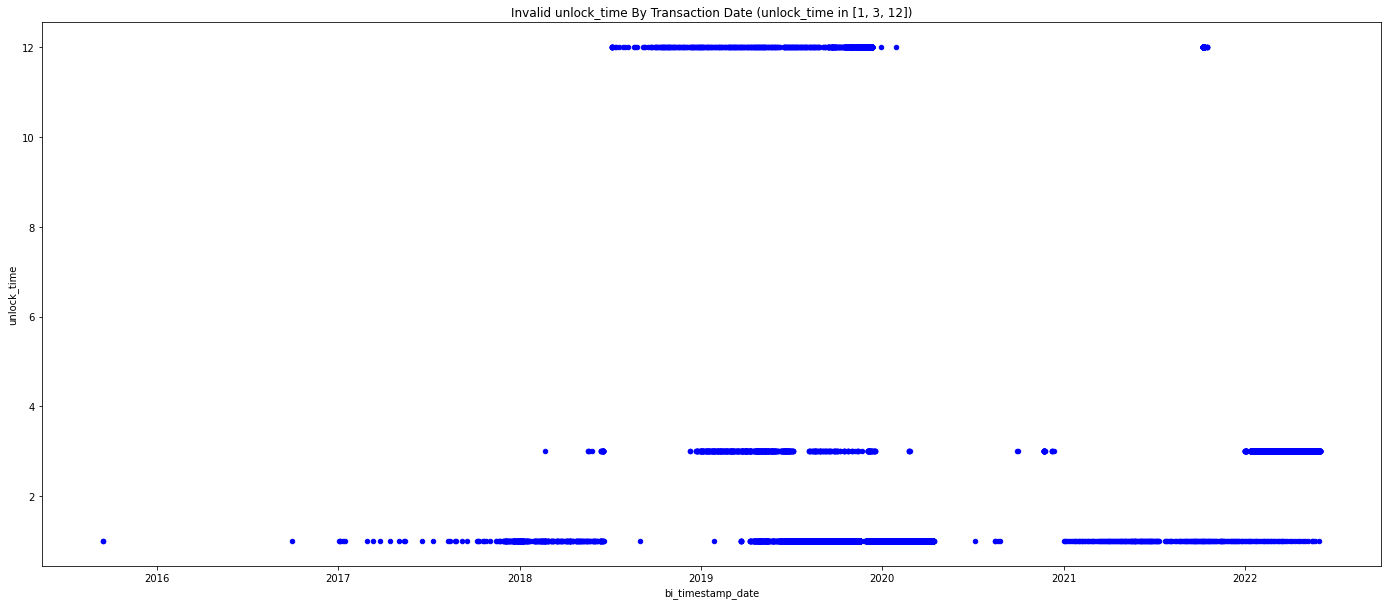

In [15]:
invalid_unlock_times[(invalid_unlock_times["unlock_time"] == 1) | (invalid_unlock_times["unlock_time"] == 3) | (invalid_unlock_times["unlock_time"] == 12)].plot(kind="scatter",
                                                                       y="unlock_time",
                                                                       x="bi_timestamp_date",
                                                                       color="blue",
                                                                       figsize=(24,10))
plt.title("Invalid unlock_time By Transaction Date (unlock_time in [1, 3, 12])");

In [16]:
small_invalid_unlock_time = pd.DataFrame(invalid_unlock_times[invalid_unlock_times["unlock_time"] <= 100]["unlock_time"].value_counts().sort_index())
small_invalid_unlock_time.index.name = "unlock_time"
small_invalid_unlock_time = small_invalid_unlock_time.rename(columns={"unlock_time": "count"})
small_invalid_unlock_time.reset_index()

,unlock_time,count
0,1,8371
1,2,391
2,3,2291
3,4,266
4,5,18
5,6,6
6,9,45
7,10,709
8,11,155
9,12,2756


## VI. Invalid unlock_time > 100

There are few enough invalid unlock_time transactions > 100 that they can be displayed in a table.

In [17]:
pd.set_option("display.max_rows", None)
invalid_unlock_times[invalid_unlock_times["unlock_time"] > 100].reset_index(drop=True).sort_values("bi_timestamp")

,tx_hash,block_id,unlock_time,bi_timestamp,bi_timestamp_date,bi_timestamp_my,invalid_unlock_time,block_unlock_time,date_unlock_time
0,8e4618d8d658d959f9eee2675286feb264c1857b6aee23...,1202128,1202127,1481834327,2016-12-15 20:38:47+00:00,2016-12,1,0,0
1,b22edc6944cba118e55ebdc4827cd452fd0aad12efeb5f...,1331616,1331614,1497357226,2017-06-13 12:33:46+00:00,2017-06,1,0,0
2,79f43aabb009b133c8f44cd06a28755534b0cd717109b1...,1376506,1000000,1502724745,2017-08-14 15:32:25+00:00,2017-08,1,0,0
3,9c5664138dd722215b2ac9e7c0949ae77e1123c8763ddf...,1883222,1883221,1563697319,2019-07-21 08:21:59+00:00,2019-07,1,0,0
4,8079dce681460d35ae2ffb4ab5e870cca7843b3242e7ed...,1883237,1883236,1563698855,2019-07-21 08:47:35+00:00,2019-07,1,0,0
5,5e54103f9240dcc983a0c3039f48976bcd7cc3643cda75...,1883247,1883247,1563700253,2019-07-21 09:10:53+00:00,2019-07,1,0,0
7,dd85bf4e6c698df8b0eb6fdbcb1d092a45bfa8a101212f...,2136246,2136246,1594032973,2020-07-06 10:56:13+00:00,2020-07,1,0,0
8,506c62de0c5372f3b0180ec23bf6c90feb871aa3bc0e95...,2136246,2136246,1594032973,2020-07-06 10:56:13+00:00,2020-07,1,0,0
6,dd3bb72d4bf83fd3ebeab02a2eb474d2d465cb85a5f965...,2136246,2136245,1594032973,2020-07-06 10:56:13+00:00,2020-07,1,0,0
9,3f4b54bb25649eab2ed5b856d76df4052e35e84ac1edf0...,2136255,2136255,1594034012,2020-07-06 11:13:32+00:00,2020-07,1,0,0
